In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
# make sure the data is available under "<root_project_folder>/data"

DATA_DIR= Path("../data")
train_data_path = "train_file.xlsx"
test_data_path = "test_file.xlsx"

### Load data and check quality, basic statistics and fields

In [3]:
# load trainig data and get first impression on fields and  values
train_data = pd.read_excel(DATA_DIR / train_data_path)
print(f"Data Size: {train_data.shape[0]}")
train_data.head()

Data Size: 32910


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,no


In [4]:
# load test data and get first impression on fields and  values
test_data = pd.read_excel(DATA_DIR / test_data_path)
print(f"Data Size: {test_data.shape[0]}")
test_data.head()

Data Size: 40


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome
0,34,services,married,high.school,no,no,no,telephone,may,thu,214,4,0,nonexistent
1,29,blue-collar,single,basic.9y,no,no,no,cellular,jul,thu,190,1,0,nonexistent
2,35,admin.,single,high.school,no,no,no,cellular,may,wed,152,2,0,nonexistent
3,60,admin.,divorced,high.school,no,yes,no,cellular,jul,fri,179,1,0,nonexistent
4,45,management,married,university.degree,no,no,no,telephone,may,wed,105,2,0,nonexistent


In [81]:
# get high level overview on features statistics
display(train_data.describe())
display(train_data.describe(include="object"))

,age,duration,campaign,previous
count,32910.0000,32910.0000,32910.0000,32910.0000
mean,40.0141,258.1643,2.5606,0.1748
std,10.4029,259.0703,2.7533,0.4992
min,17.0000,0.0000,1.0000,0.0000
25%,32.0000,103.0000,1.0000,0.0000
50%,38.0000,180.0000,2.0000,0.0000
75%,47.0000,319.0000,3.0000,0.0000
max,98.0000,4918.0000,56.0000,7.0000


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,32910,32910,32910,32910,32910,32910,32910,32910,32910,32910,32910
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,8305,19929,9727,25975,17236,27099,20890,10993,6849,28380,29203


In [6]:
# check for nan values in data to avoid sparse features
train_data.isna().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
previous       0
poutcome       0
y              0
dtype: int64

### Explore Features in Train Data

The easiest way to evaluate feature importance is usually to do it through the model training (especially with categorical features vs categorical outcome). Before we proceed directly to that, it would be beneficial to have a brief look at the features and their distribution with respect to the outcome groups. This would help to decide which features are useful and which might be potential harmful for the model, as well as to get to know the data a bit better. 
In the script bellow we will do the following:
* For features that are numerical we will look at their distribution between two different groups and assess the influence of the group with hypothesis testing (we will preliminary test for normality of the distribution)
* For features that are cetegorical we will look at the cross tabulation (accompanied by the bar plots for better understanding) 


In [7]:
train_data.groupby("y").apply(func=lambda df_gr: pd.Series(
    {
        "count": len(df_gr),
        "percentage": np.round((len(df_gr)*100)/len(train_data),2)
    }
), include_groups=False)

,count,percentage
y,,
no,29203.0,88.74
yes,3707.0,11.26


*Note: dataset is clearly unbalanced, we should be careful about results evaluation, precision and recall in this case (and F1 score) would be a better metrics*

#### A brief analysis to see if there are obvious relationships between features and the outcome

In [8]:
def run_hypothesis_testing(data: pd.DataFrame, feature: str):
    """
    Since we have two groups (two possible outcomes), we can run hypothesis testing to see if a continuous variable has an impact on the outcome.

    """
    print(f"Analysing dependency between {feature.upper()} and Outcome")
    group_0 = data[data['y'] == "no"][feature]
    group_1 = data[data['y'] == "yes"][feature]

    stat_1, p_1 = stats.shapiro(group_1)
    stat_0, p_0 = stats.normaltest(group_0)

    norm_text = f"Normality Test (p<0.05 means non-normal):\n"
    norm_text += f"Outcome=0: p={p_0:.4f} {'(non-normal)' if p_0<0.05 else '(normal)'}\n"
    norm_text += f"Outcome=1: p={p_1:.4f} {'(non-normal)' if p_1<0.05 else '(normal)'}"
    print(norm_text)

    plt.figure(figsize=(15,5))
    sns.histplot(group_0, kde=True, color='blue', label='Outcome = no')
    sns.histplot(group_1, kde=True, color='red', alpha=0.7, label='Outcome = yes')
    plt.title(f'{feature.capitalize()} distribution by Outcome Group')
    plt.xlabel(f'{feature}')
    plt.legend()
    plt.show()
    
    stat, p_value = stats.mannwhitneyu(group_0, group_1, alternative='two-sided')

    print(f"Mann-Whitney U test: U={stat:.3f}, p-value={p_value:.4f}")
    if p_value < 0.05:
        print("The distributions of the two groups are significantly different")
    else:
        print("There's not enough evidence to say the distributions differ.")


def run_analysis_of_categorical_feature(data: pd.DataFrame, feature: str):
    return train_data.groupby([feature, "y"]).apply(func=lambda df_gr: pd.Series(
        {
            "count": len(df_gr),
            "percentage": np.round((len(df_gr)*100)/len(train_data),2)
        }
    ), include_groups=False)

Analysing dependency between AGE and Outcome
Normality Test (p<0.05 means non-normal):
Outcome=0: p=0.0000 (non-normal)
Outcome=1: p=0.0000 (non-normal)


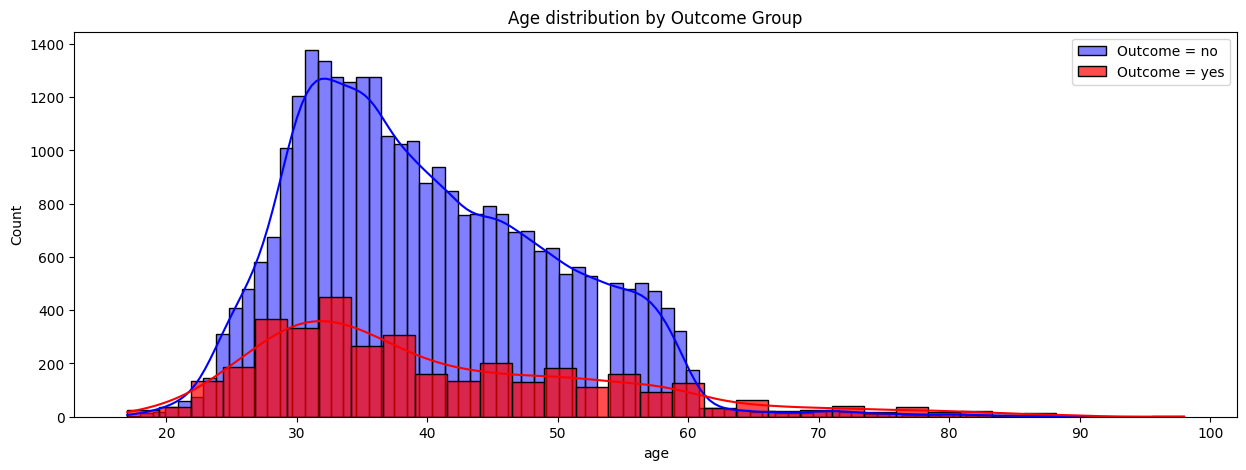

Mann-Whitney U test: U=55389642.500, p-value=0.0205
The distributions of the two groups are significantly different


In [9]:
run_hypothesis_testing(train_data, "age")

Analysing dependency between DURATION and Outcome
Normality Test (p<0.05 means non-normal):
Outcome=0: p=0.0000 (non-normal)
Outcome=1: p=0.0000 (non-normal)


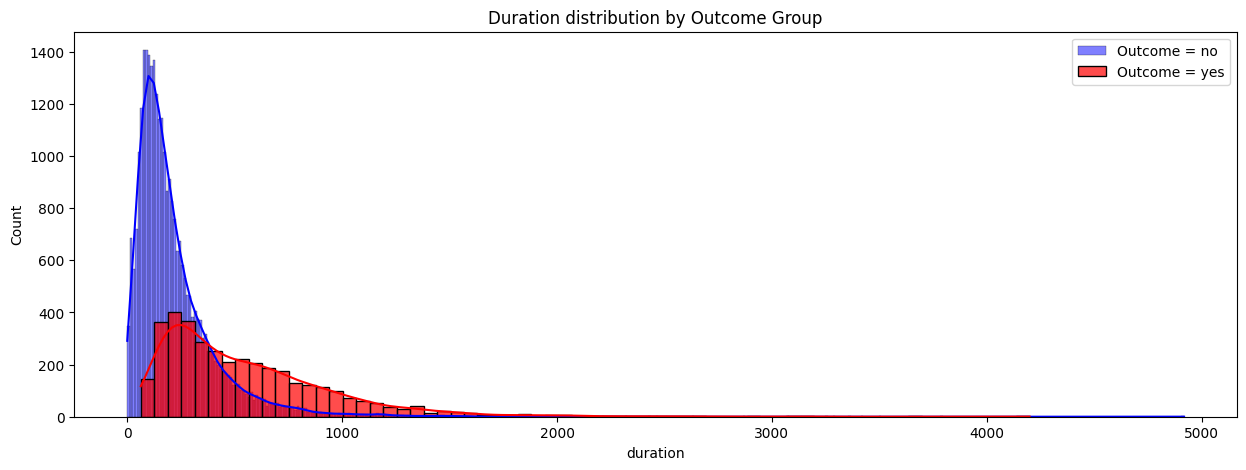

Mann-Whitney U test: U=19771482.500, p-value=0.0000
The distributions of the two groups are significantly different


In [10]:
run_hypothesis_testing(train_data, "duration")

In [79]:
def analyze_categorical_vs_outcome(df, categorical_column, outcome_column='y'):
    # Calculate overall distribution of the categorical variable
    total_dist = df[categorical_column].value_counts(normalize=True) * 100
    
    # Create a DataFrame for results
    result = pd.DataFrame({
        'Overall %': total_dist,
        'Outcome_no %': df[df[outcome_column]=="no"][categorical_column].value_counts(normalize=True) * 100,
        'Outcome_yes %': df[df[outcome_column]=="yes"][categorical_column].value_counts(normalize=True) * 100
    }).round(2)
    
    # Add count columns for reference
    result['Total_Count'] = df[categorical_column].value_counts()
    result['Outcome_No_Count'] = df[df[outcome_column]=="no"][categorical_column].value_counts()
    result['Outcome_Yes_Count'] = df[df[outcome_column]=="yes"][categorical_column].value_counts()

    plot_categorical_analysis(df, categorical_column)
    perform_chi_squared_tests(df, categorical_column)
    return result

def plot_categorical_analysis(df, categorical_column, outcome_column='y'):
    plt.figure(figsize=(15,5))
    sns.countplot(data=df, x=categorical_column, hue=outcome_column, palette={"yes":"coral", "no":"silver"})
    plt.title(f'Count of Outcomes by {categorical_column}')
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.show()

def perform_chi_squared_tests(df, categorical_column, target_column='y'):
    contingency = pd.crosstab(df[categorical_column], df[target_column])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

    if p_value<0.05:
        print(f"Statistically significant relationship between {categorical_column} and Outcome: p-value {p_value:.4f}")
    else:
        print(f"There's not enough evidence to say the distributions differ: p-value {p_value:.4f}")
    
    

In [53]:
categorical_columns = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 
    'month', 'day_of_week', 'campaign', 'previous', 'poutcome']

JOB


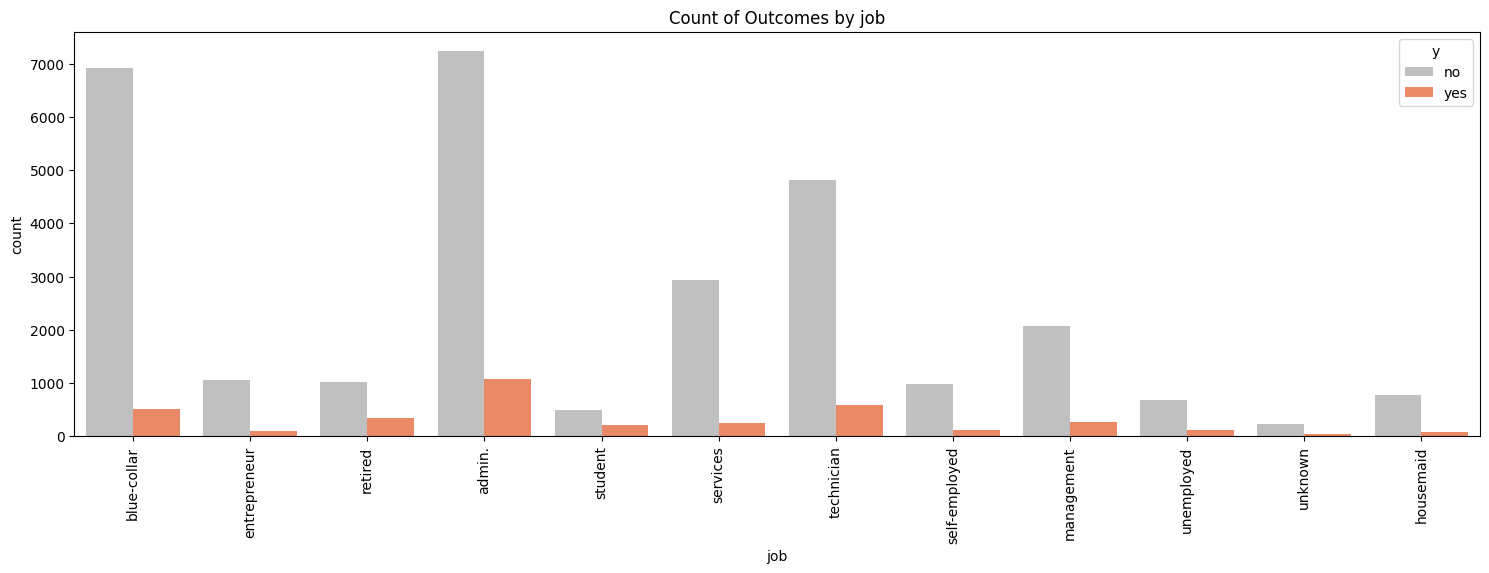

Statistically significant relationship between job and Outcome: p-value 0.0000


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
job,,,,,,
admin.,25.2400,24.7700,28.8600,8305,7235,1070
blue-collar,22.5800,23.6800,13.8700,7430,6916,514
entrepreneur,3.5200,3.6300,2.7000,1159,1059,100
housemaid,2.6000,2.6300,2.3200,855,769,86
management,7.1200,7.1000,7.2600,2343,2074,269
retired,4.1400,3.4800,9.3600,1364,1017,347
self-employed,3.3400,3.3500,3.2100,1098,979,119
services,9.7000,10.0600,6.8500,3192,2938,254
student,2.1600,1.6900,5.8300,710,494,216



MARITAL


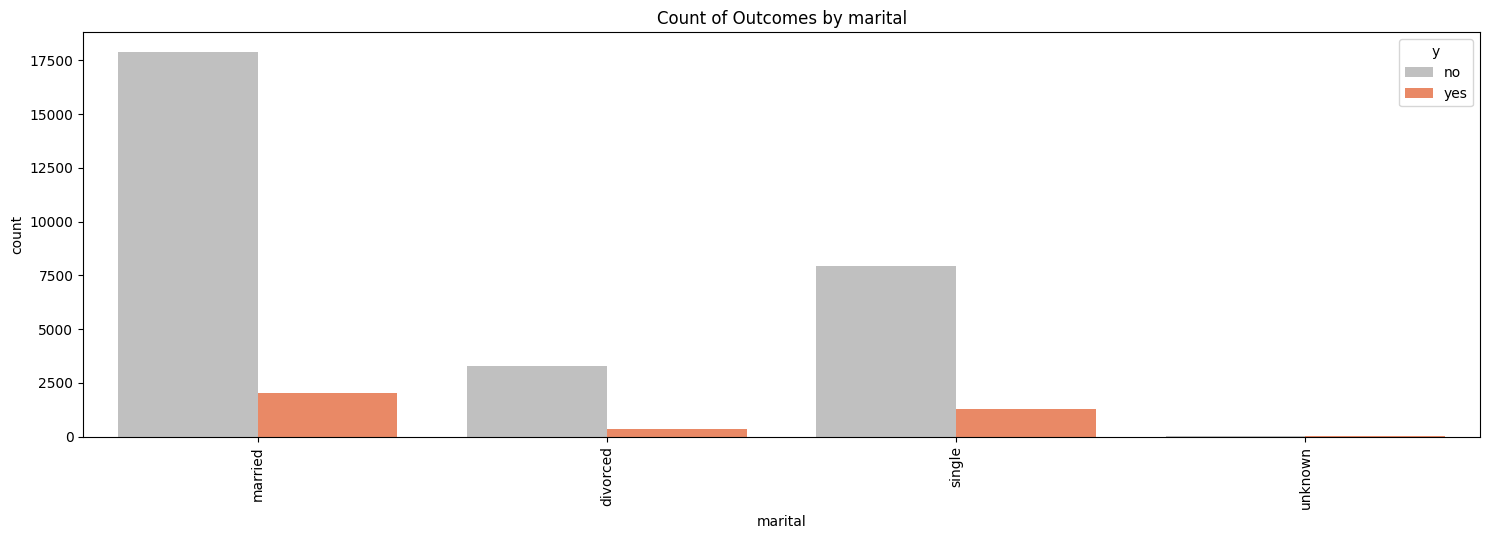

Statistically significant relationship between marital and Outcome: p-value 0.0000


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
marital,,,,,,
married,60.5600,61.3300,54.4600,19929,17910,2019
single,28.0900,27.1900,35.2300,9245,7939,1306
divorced,11.1500,11.3000,10.0100,3671,3300,371
unknown,0.2000,0.1800,0.3000,65,54,11



EDUCATION


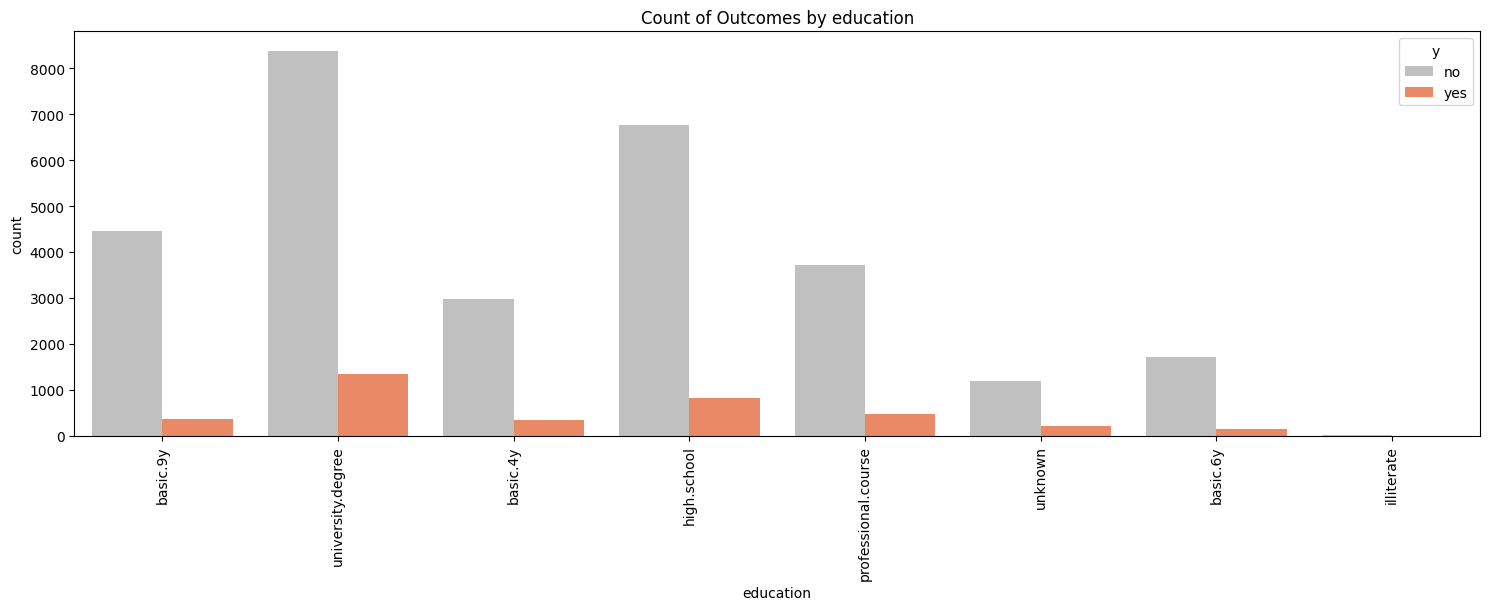

Statistically significant relationship between education and Outcome: p-value 0.0000


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
education,,,,,,
basic.4y,10.0900,10.2000,9.2800,3322,2978,344
basic.6y,5.6600,5.8500,4.2100,1863,1707,156
basic.9y,14.6400,15.2400,9.9300,4818,4450,368
high.school,23.0500,23.1900,21.9600,7585,6771,814
illiterate,0.0500,0.0400,0.0800,16,13,3
professional.course,12.7100,12.7100,12.7100,4184,3713,471
university.degree,29.5600,28.7100,36.2600,9727,8383,1344
unknown,4.2400,4.0700,5.5800,1395,1188,207



DEFAULT


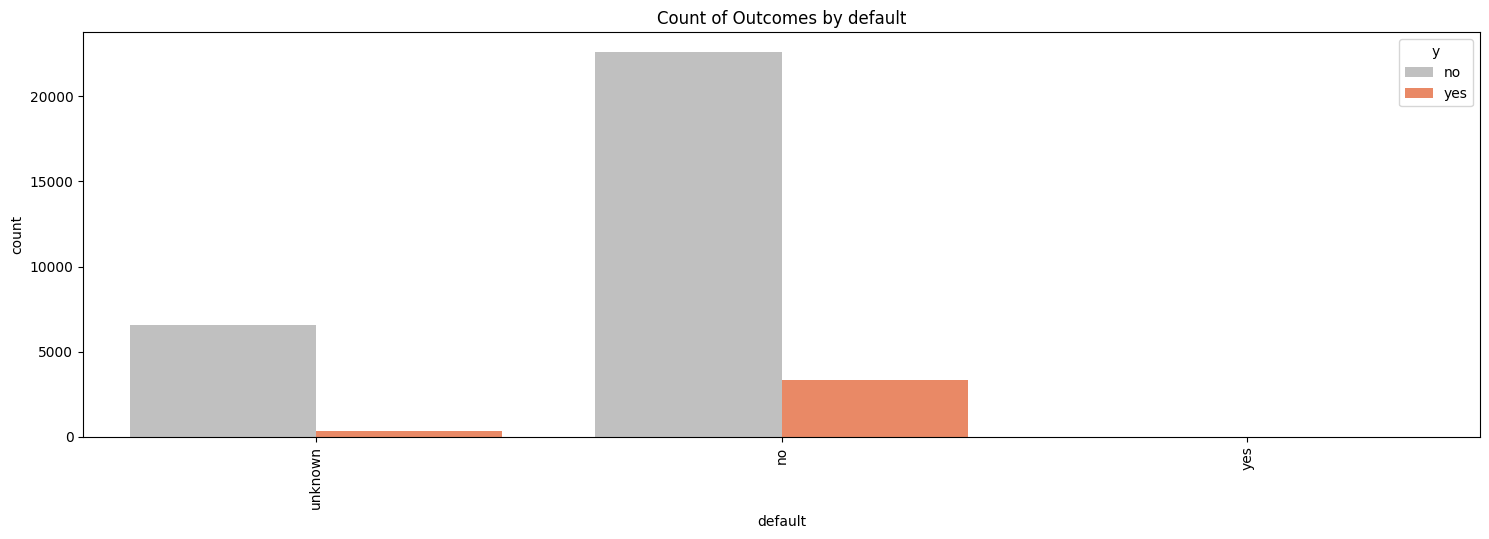

Statistically significant relationship between default and Outcome: p-value 0.0000


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
default,,,,,,
no,78.9300,77.4900,90.2900,25975,22628,3347.0000
unknown,21.0600,22.5000,9.7100,6932,6572,360.0000
yes,0.0100,0.0100,NaN,3,3,NaN



HOUSING


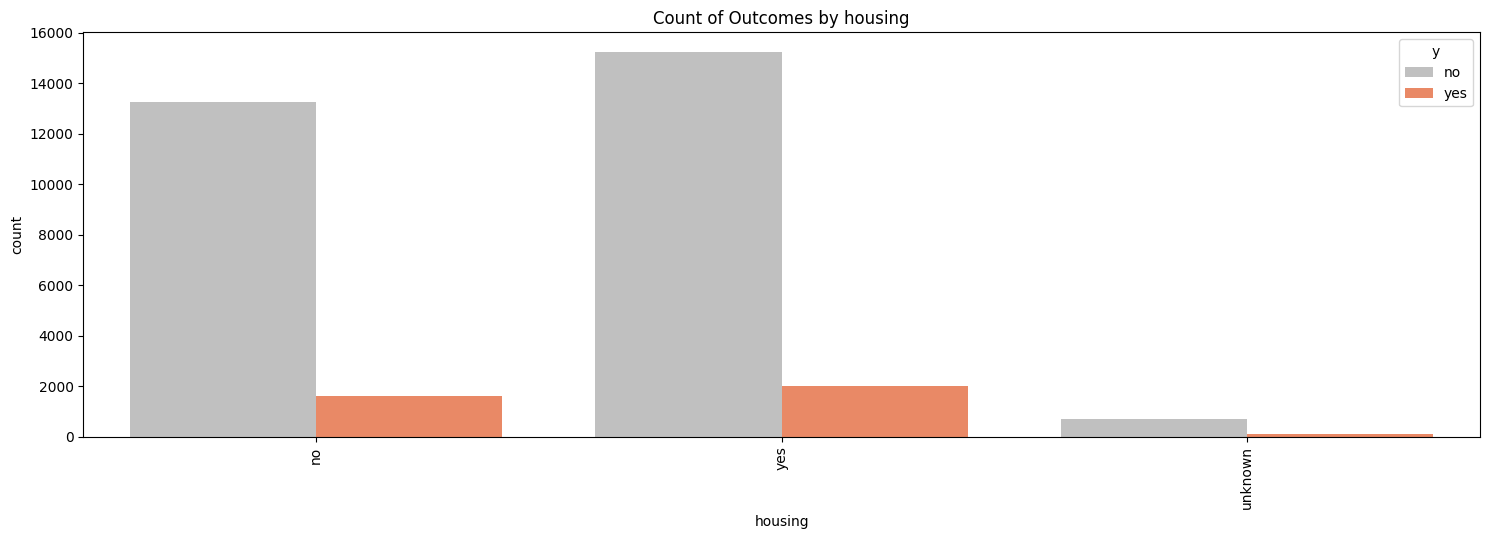

There's not enough evidence to say the distributions differ: p-value 0.2116


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
housing,,,,,,
yes,52.3700,52.2000,53.7100,17236,15245,1991
no,45.2100,45.3800,43.8600,14879,13253,1626
unknown,2.4200,2.4100,2.4300,795,705,90



LOAN


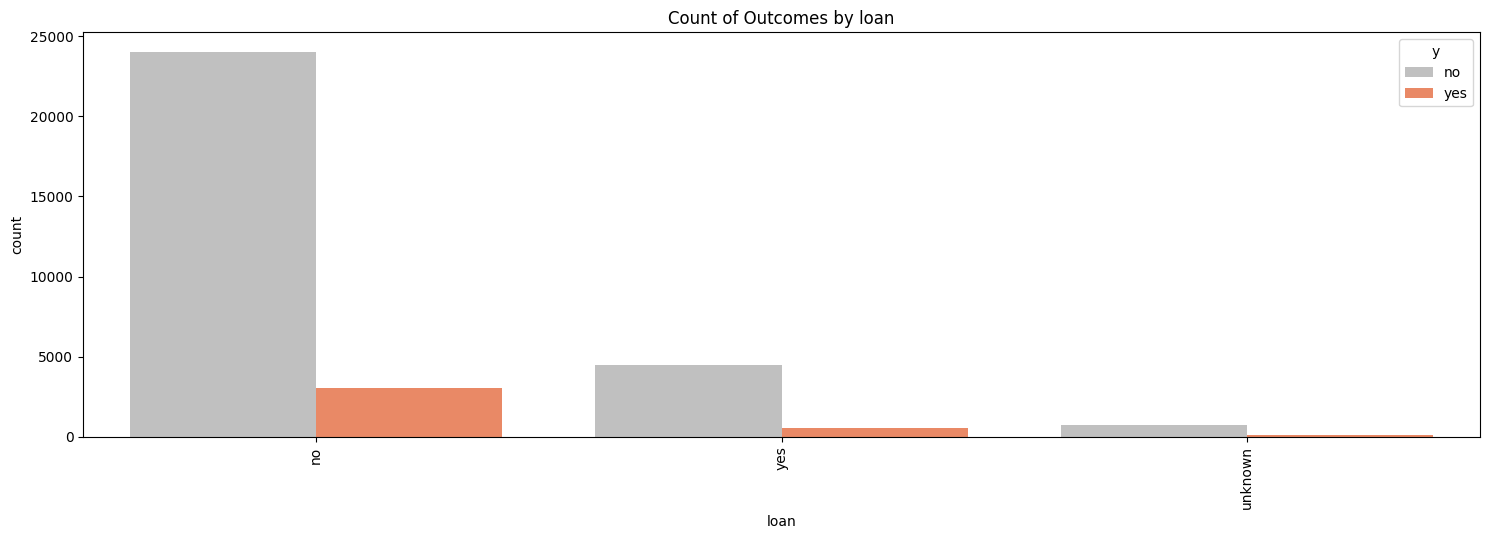

There's not enough evidence to say the distributions differ: p-value 0.9886


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
loan,,,,,,
no,82.3400,82.3300,82.4100,27099,24044,3055
yes,15.2400,15.2500,15.1600,5016,4454,562
unknown,2.4200,2.4100,2.4300,795,705,90



CONTACT


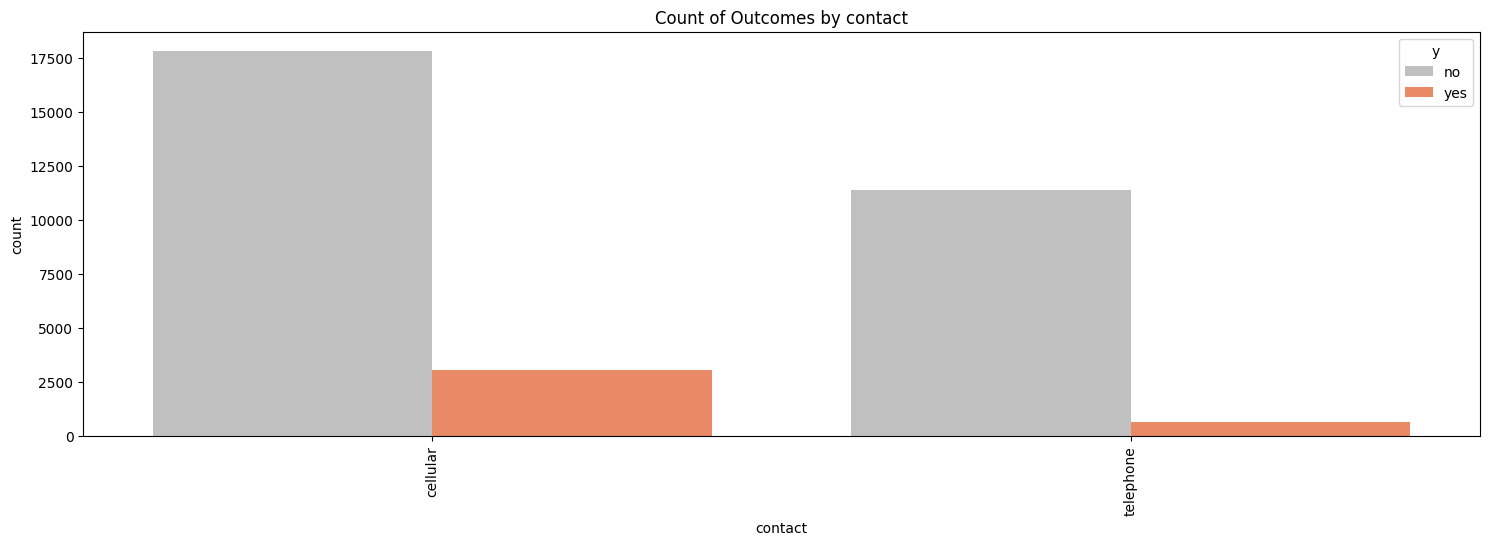

Statistically significant relationship between contact and Outcome: p-value 0.0000


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
contact,,,,,,
cellular,63.4800,61.0200,82.8200,20890,17820,3070
telephone,36.5200,38.9800,17.1800,12020,11383,637



MONTH


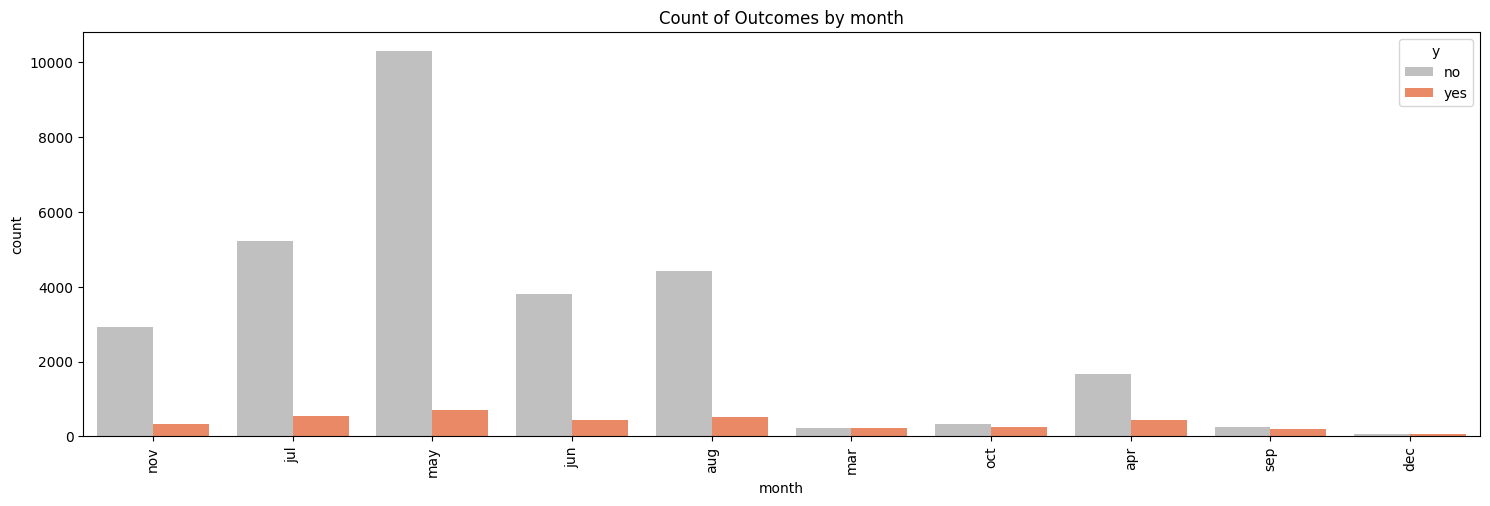

Statistically significant relationship between month and Outcome: p-value 0.0000


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
month,,,,,,
apr,6.3300,5.6700,11.4900,2083,1657,426
aug,15.0300,15.1200,14.3000,4946,4416,530
dec,0.4300,0.2400,1.9400,143,71,72
jul,17.4800,17.8800,14.3500,5753,5221,532
jun,12.8900,13.0200,11.8400,4242,3803,439
mar,1.3200,0.7500,5.8500,436,219,217
may,33.4000,35.2500,18.8300,10993,10295,698
nov,9.9100,10.0400,8.9600,3263,2931,332
oct,1.7800,1.1400,6.8500,587,333,254



DAY_OF_WEEK


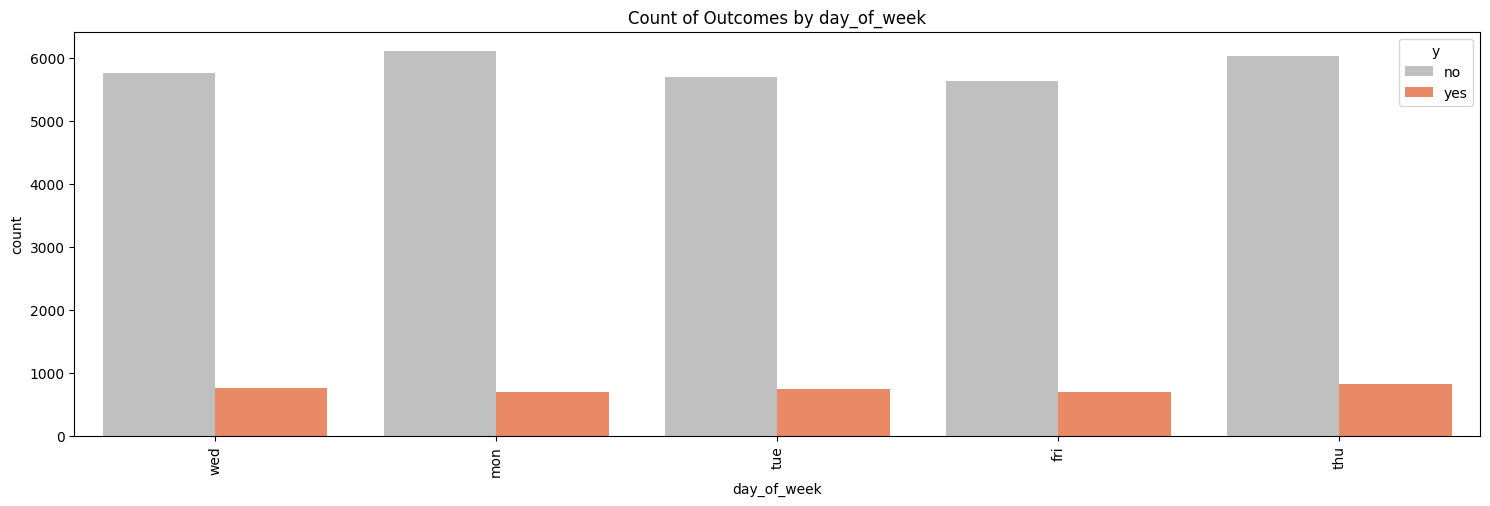

Statistically significant relationship between day_of_week and Outcome: p-value 0.0112


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
day_of_week,,,,,,
fri,19.1800,19.2500,18.5900,6312,5623,689
mon,20.6700,20.9100,18.7800,6802,6106,696
thu,20.8100,20.6400,22.1500,6849,6028,821
tue,19.5700,19.4900,20.1800,6439,5691,748
wed,19.7800,19.7100,20.3100,6508,5755,753



CAMPAIGN


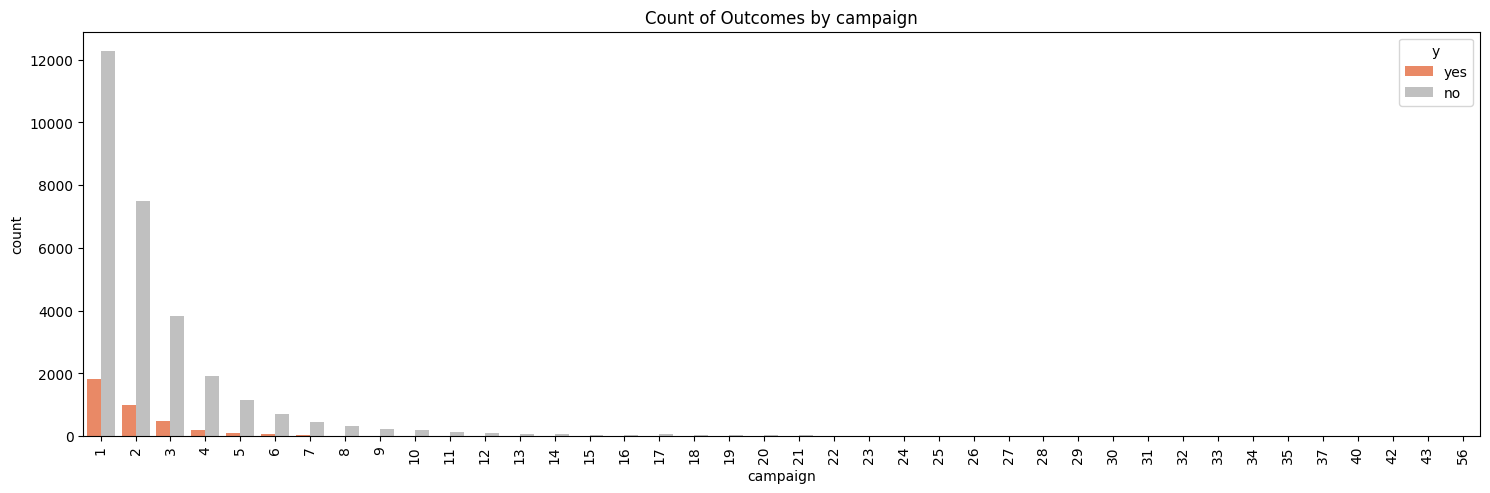

Statistically significant relationship between campaign and Outcome: p-value 0.0000


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
campaign,,,,,,
1,42.8600,42.0700,49.0700,14104,12285,1819.0000
2,25.7200,25.6200,26.4900,8463,7481,982.0000
3,13.0500,13.1200,12.4900,4295,3832,463.0000
4,6.4100,6.5300,5.4800,2110,1907,203.0000
5,3.8000,3.9800,2.3700,1251,1163,88.0000
6,2.3500,2.4300,1.7000,773,710,63.0000
7,1.4900,1.5600,0.9200,491,457,34.0000
8,1.0000,1.0800,0.3500,329,316,13.0000
9,0.6700,0.7100,0.3200,220,208,12.0000



PREVIOUS


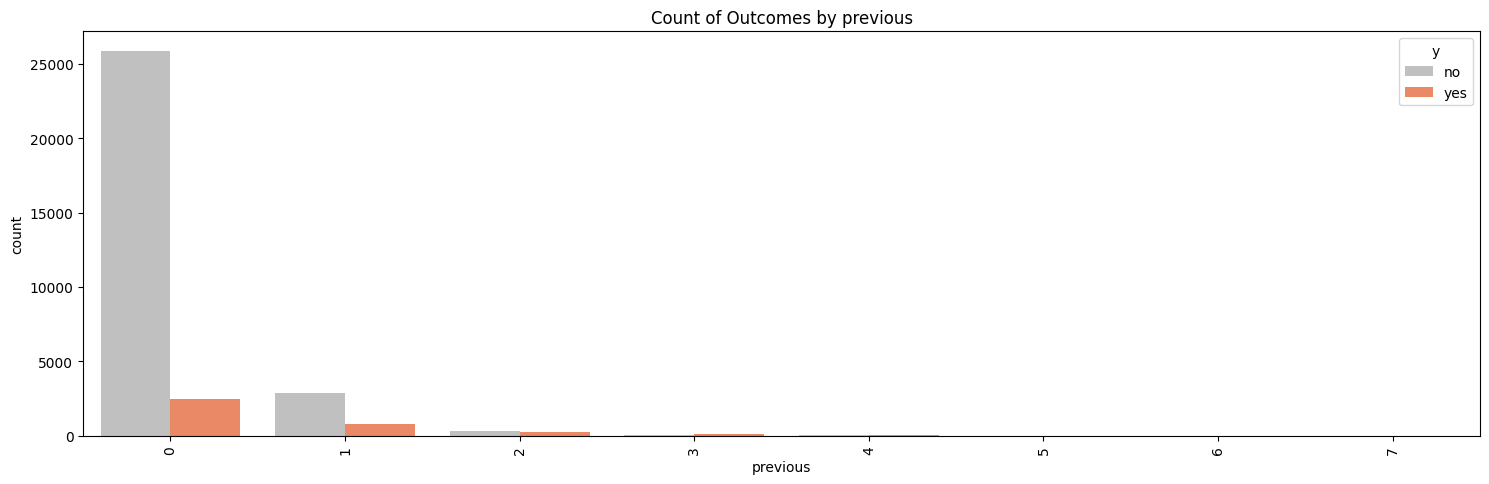

Statistically significant relationship between previous and Outcome: p-value 0.0000


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
previous,,,,,,
0,86.2400,88.6300,67.3600,28380,25883,2497.0000
1,11.1500,9.8800,21.1200,3669,2886,783.0000
2,1.8400,1.1100,7.6100,606,324,282.0000
3,0.5300,0.2500,2.7200,175,74,101.0000
4,0.1800,0.1000,0.8400,60,29,31.0000
5,0.0400,0.0100,0.2700,14,4,10.0000
6,0.0200,0.0100,0.0800,5,2,3.0000
7,0.0000,0.0000,NaN,1,1,NaN



POUTCOME


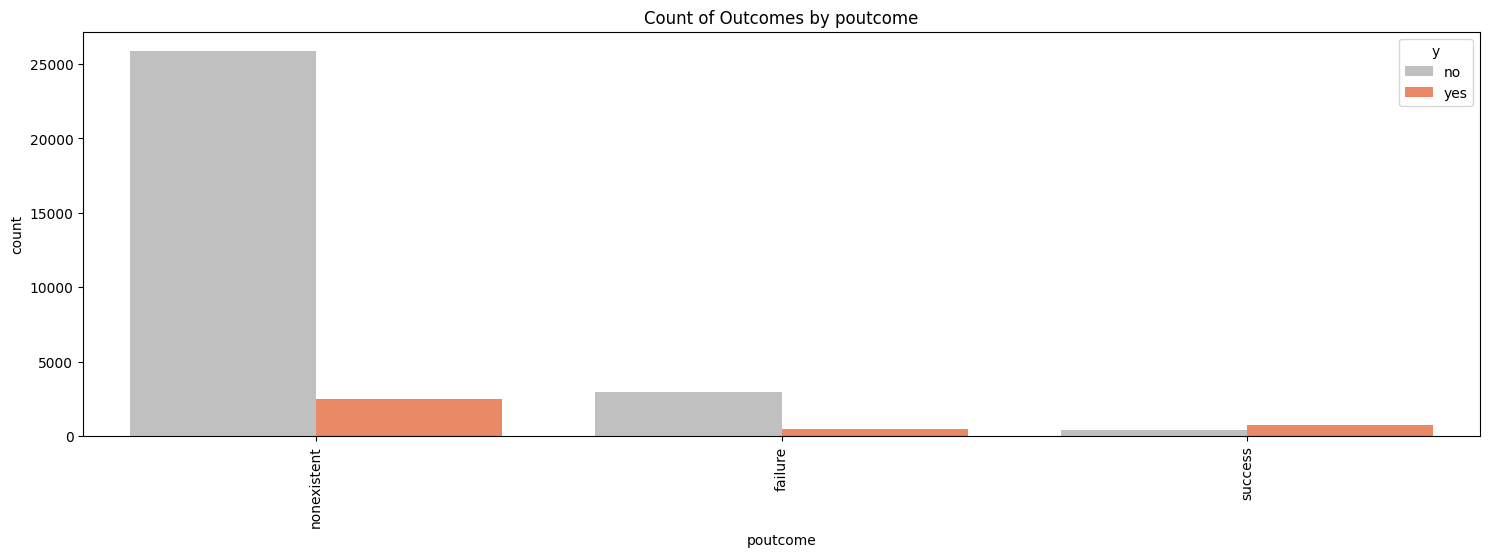

Statistically significant relationship between poutcome and Outcome: p-value 0.0000


,Overall %,Outcome_no %,Outcome_yes %,Total_Count,Outcome_No_Count,Outcome_Yes_Count
poutcome,,,,,,
failure,10.4100,10.0400,13.3300,3426,2932,494
nonexistent,86.2400,88.6300,67.3600,28380,25883,2497
success,3.3500,1.3300,19.3100,1104,388,716


In [80]:
for feature in categorical_columns: 
    print(feature.upper())
    display(analyze_categorical_vs_outcome(train_data, feature))
    print()

#### Conclusion:
* Both Numerical features: age and duration, seem to have relationship to outcome. However, duration might be not applicable to our usecase if we want to predict the outcome before the call, as duration of the call increases as the chances of getting the positive outcome increase.
Therefore we will **discard duration as a feature for further model training**
* Lets sort out categorical features:
  * Job, Marital, Education, Contact, Month, Day of Week - these features seem to have significant relationship, we will keep them for further model training
  * Housing and Loan do not seem to have statistically significant difference in both groups, therefore we will **discard loan and housing as features for further model training**
  * Campaign is a feature with high cardinality, but only top-10 of the categories have reasonable amount of saples, this might lead to the model overfit therefore for now we will **discard campaing as feature for further model training** (for this feature it would be good to have a contex to know how to utilize it effectively: i.e. what defines campaign in this context)
  * Thre are some features-predictors that seem to have stastically significant relationship but might be rather harmful:
    * Default - not clear what this feature means, but it might be already some predictor on its own that is assigned to the individual based on the other features combination
    * Previous - this feature is useful in the context if we assume there were no predictors used to collect the current data, otherwise this feature might reinforce the bias of the previous predictor
    * Poutcome - without the context it is not clear how this feature is determined
For now we will leave those features in and see what does the model make out of it.

### Model Selection and Training

We will try classical methods to start with when working with tabular data:
* RandomForestClassifier
* GradientBoostClassifier
* XGBoostClassifier
* SVM

The goal of this phase is to get a feeling what works better for the data. 

Note that these methods do not support string data for categories, therefore we need to use encoding, we try out two i the current set up: OneHotEncofing and TargetEncoding.

To address the issue of class imbalance we use two things:
* Metrics that accounts for the count of samples in the class (precision and recall)
* Balansing of weights in the classifiers

Data Split:
* We will split the train_data file into three chunks: train/valid/test with 80/20/20
* We won't evaluate anythin on out test split, and use valid split to find the best model, we will use test split to evaluate that mode in the end



In [126]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [127]:
results_df = pd.DataFrame()


def evaluate_model(model, X, y, data_type, results_df):
    y_pred = model.predict(X)
    precision, recall, f1, support = precision_recall_fscore_support(y, y_pred, average=None)

    if hasattr(model, 'steps'):
        model_type = model.steps[-1][1].__class__.__name__
        model_params = model.steps[-1][1].get_params()
    else:
        model_type = type(model).__name__
        model_params = model.get_params()

    classes = np.unique(y)
    results_dict = {
        'Model': f"{model_type} ({str(model_params)})",
        'Data': data_type
    }

    for i, class_label in enumerate(classes):
        results_dict.update({
            f'precision_{class_label}': precision[i],
            f'recall_{class_label}': recall[i],
            f'f1_{class_label}': f1[i],
            f'support_{class_label}': support[i]
        })

    results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)

    return results_df

def get_data_split(data_input: pd.DataFrame):
    categorical_features = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'previous', 'default', 'poutcome']
    numerical_features = ['age']
    target = 'y'

    data = data_input[categorical_features+numerical_features+[target]]

    X = train_data.drop(target, axis=1)
    y = train_data[target]

    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=0.1, random_state=42)
    print(f"Data Split: Train {X_train.shape[0]}, Validation {X_valid.shape[0]}, Test {X_test.shape[0]}")

    return X_train, X_valid, X_test, y_train, y_valid, y_test


In [128]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_data_split(train_data)

encoding="ohe" #or target

if encoding=="ohe":
    print("Using OneHotEncoder for categorical features")
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"), categorical_features),
            ('numerical', StandardScaler(), numerical_features)
        ],
        remainder='passthrough'
    )
elif encoding=="target":
    print("Using TargetEncoder for categorical features")

    preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', TargetEncoder(), categorical_features),
        ('numerical', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)


Data Split: Train 26657, Validation 2962, Test 3291
Using OneHotEncoder for categorical features


In [129]:
# Train RandomForestClassifier

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight="balanced"))
])


model.fit(X_train, y_train)

results_df = evaluate_model(
    model=model, 
    X=X_valid, 
    y=y_valid, 
    data_type="valid", 
    results_df=results_df)

results_df = evaluate_model(
    model=model, 
    X=X_train, 
    y=y_train, 
    data_type="train", 
    results_df=results_df)


In [130]:
# Train GradientBoostClassifier
gb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=10,
        random_state=42,
    ))
])

weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )

sample_weights = np.array([weights[i] for i in y_train])

gb_model.fit(X_train, y_train, classifier__sample_weight=sample_weights)


results_df = evaluate_model(
    model=gb_model, 
    X=X_valid, 
    y=y_valid, 
    data_type="valid", 
    results_df=results_df)

results_df = evaluate_model(
    model=gb_model, 
    X=X_train, 
    y=y_train, 
    data_type="train", 
    results_df=results_df)

In [131]:
# Train XGBoost Classifier

xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
    ))
])

weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )

sample_weights = np.array([weights[i] for i in y_train])

xgb_model.fit(X_train, y_train, classifier__sample_weight=sample_weights)

results_df = evaluate_model(
    model=xgb_model, 
    X=X_valid, 
    y=y_valid, 
    data_type="valid", 
    results_df=results_df)

results_df = evaluate_model(
    model=xgb_model, 
    X=X_train, 
    y=y_train, 
    data_type="train", 
    results_df=results_df)

In [137]:
# Train SVM Classifier
svm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        kernel='poly',
        degree=3,
        C=0.1,
        random_state=42,
        class_weight="balanced"
    ))
])
svm_model.fit(X_train, y_train)

results_df = evaluate_model(
    model=svm_model, 
    X=X_valid, 
    y=y_valid, 
    data_type="valid", 
    results_df=results_df)

results_df = evaluate_model(
    model=svm_model, 
    X=X_train, 
    y=y_train, 
    data_type="train", 
    results_df=results_df)

In [138]:
# example of training results
results_df

,Model,Data,precision_0,recall_0,f1_0,support_0,precision_1,recall_1,f1_1,support_1
0,"RandomForestClassifier ({'bootstrap': True, 'c...",valid,0.941509,0.881420,0.910474,2648,0.349896,0.538217,0.424090,314
1,"RandomForestClassifier ({'bootstrap': True, 'c...",train,0.940696,0.891789,0.915590,23639,0.397692,0.559642,0.464969,3018
2,"GradientBoostingClassifier ({'ccp_alpha': 0.0,...",valid,0.929996,0.862915,0.895201,2648,0.281188,0.452229,0.346764,314
3,"GradientBoostingClassifier ({'ccp_alpha': 0.0,...",train,0.981858,0.911206,0.945214,23639,0.555202,0.868125,0.677265,3018
4,XGBClassifier ({'objective': 'binary:logistic'...,valid,0.945401,0.850076,0.895208,2648,0.316695,0.585987,0.411173,314
5,XGBClassifier ({'objective': 'binary:logistic'...,train,0.941449,0.859089,0.898385,23639,0.345065,0.581511,0.433119,3018
6,"SVC ({'C': 0.5, 'break_ties': False, 'cache_si...",valid,0.937926,0.884441,0.910398,2648,0.341935,0.506369,0.408216,314
7,"SVC ({'C': 0.5, 'break_ties': False, 'cache_si...",train,0.928967,0.886290,0.907127,23639,0.345029,0.469185,0.397641,3018
8,"SVC ({'C': 0.5, 'break_ties': False, 'cache_si...",valid,0.945455,0.864048,0.902920,2648,0.335793,0.579618,0.425234,314
9,"SVC ({'C': 0.5, 'break_ties': False, 'cache_si...",train,0.943513,0.871230,0.905932,23639,0.369642,0.591451,0.454951,3018


#### Conclusion:
* The performance of the models are rather similar
* This performance does not look optimal, recall is higher than precision, which might be beneficial depending on the usecase, however the overall performance could have been better
* OneHotEncoder with RandomForestClassifier seem to be a good option for the further hyperparameter tuning

### Hyperparameter Optimization

Since we found the model that performs slightly better than others, we want to see if we can improve that performance with hyperparameter tuning

In [92]:
import optuna
from sklearn.model_selection import cross_val_score

In [ ]:
def objective(trial):
    # Define the hyperparameter search space
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': 'balanced',
        'random_state': 42
    }
    
    rf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(**rf_params))
    ])
    
    scores = cross_val_score(
        rf, 
        X_train, 
        y_train, 
        cv=5, 
        scoring='f1_weighted',
        n_jobs=-1
    )
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
best_rf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(**best_params, class_weight='balanced', random_state=42))
    ])
best_rf.fit(X_train, y_train)

# Print results
print("Best parameters:", best_params)
print("Best cross-validation score:", study.best_value)

results_df = evaluate_model(
    model=best_rf, 
    X=X_valid, 
    y=y_valid, 
    data_type="valid", 
    results_df=results_df)

results_df = evaluate_model(
    model=best_rf, 
    X=X_train, 
    y=y_train, 
    data_type="train", 
    results_df=results_df)

### Evaluate on Test data and save the model

In [117]:
import pickle

In [142]:
results_df = pd.DataFrame()

results_df = evaluate_model(
    model=best_rf, 
    X=X_train, 
    y=y_train, 
    data_type="train", 
    results_df=results_df)

results_df = evaluate_model(
    model=best_rf, 
    X=X_valid, 
    y=y_valid, 
    data_type="valid", 
    results_df=results_df)

evaluate_model(
    model=best_rf, 
    X=X_test, 
    y=y_test, 
    data_type="test", 
    results_df=results_df)

,Model,Data,precision_0,recall_0,f1_0,support_0,precision_1,recall_1,f1_1,support_1
0,"RandomForestClassifier ({'bootstrap': True, 'c...",train,0.940040,0.893354,0.916103,23639,0.398616,0.553678,0.463523,3018
1,"RandomForestClassifier ({'bootstrap': True, 'c...",valid,0.940064,0.882553,0.910401,2648,0.346639,0.525478,0.417722,314
2,"RandomForestClassifier ({'bootstrap': True, 'c...",test,0.935519,0.880658,0.907260,2916,0.362637,0.528000,0.429967,375


In [143]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'],
                yticklabels=['No', 'Yes'])
    
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

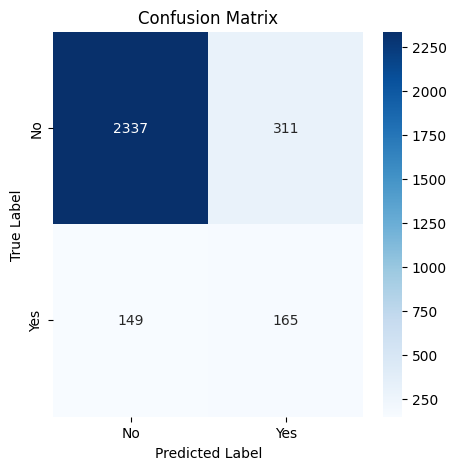

In [144]:
y_pred = best_rf.predict(X_valid)

plot_confusion_matrix(y_valid, y_pred)

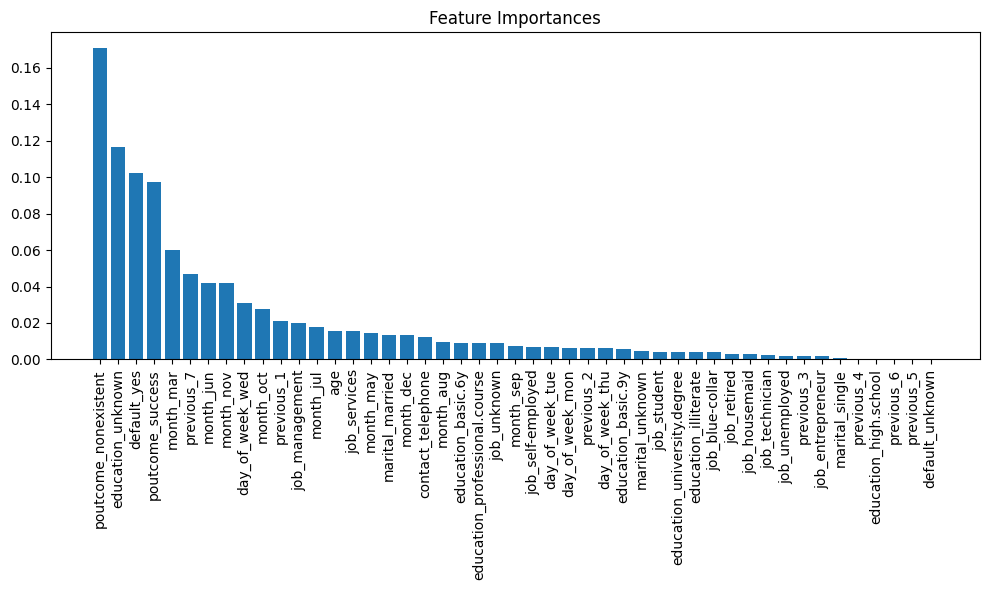

In [161]:
# Get feature importances
importances = best_rf.named_steps['classifier'].feature_importances_

categorical_names = best_rf.named_steps['preprocessor'].named_transformers_['categorical'].get_feature_names_out(input_features = categorical_features)
feature_names = numerical_features + list(categorical_names)

sorted_idx = importances.argsort()[::-1] 

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[sorted_idx])
plt.xticks(range(len(importances)), np.array(feature_names)[sorted_idx], rotation=90)
plt.tight_layout()
plt.show()


#### Conclusion: 
Overall we see that the "best" model has comparably similar performance on train/valid/test datasets, whoch suggest that:
* Model is not overfitting during training
* Because of the low numbers it is possible that model is underfitting though

In [115]:
def save_model(model, filepath='model.pkl'):
    """
    Save the trained model to a pickle file.
    
    Args:
        model: The trained scikit-learn model
        filepath: Path where the model should be saved
    """
    with open(filepath, 'wb') as file:
        pickle.dump(model, file)

In [162]:
save_model(best_rf)